In [1]:
import torch
from sklearn.pipeline import Pipeline
from skorch.callbacks import LRScheduler
from skorch.helper import predefined_split
from sklearn.base import TransformerMixin

from braindecode import EEGClassifier
from braindecode.util import set_random_seeds
from braindecode.models import ShallowFBCSPNet
from braindecode.datautil.preprocess import exponential_moving_standardize
from braindecode.datasets.moabb import MOABBDataset
from braindecode.datautil.windowers import (
    create_windows_from_events, create_fixed_length_windows)
from braindecode.datautil.preprocess import (
    MNEPreproc, NumpyPreproc, preprocess)

/home/gemeinl/anaconda3/envs/new_braindecode/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
class Preprocessor(TransformerMixin):
    def fit(self, X, y=None):
        return self
    

class EventWindower(Preprocessor):
    def __init__(self, *args, **kwargs):
        self.args=args
        self.kwargs=kwargs
        
    def transform(self, X):
        return create_windows_from_events(
            concat_ds=X, *self.args, **self.kwargs)
        
    
class FixedLengthWindower(Preprocessor):
    def __init__(self, *args, **kwargs):
        self.args=args
        self.kwargs=kwargs
        
    def transform(self, X):
        return create_fixed_length_windows(
            concat_ds=X, *self.args, **self.kwargs)

    
class MNETransformer(Preprocessor):
    def __init__(self, fn, **kwargs):
        self.pre = MNEPreproc(fn=fn, **kwargs)
    
    def transform(self, X):
        preprocess(X, [self.pre])
        return X

    
class NumpyTransformer(Preprocessor):
    def __init__(self, fn, **kwargs):
        self.pre = NumpyPreproc(fn=fn, **kwargs)
    
    def transform(self, X):
        preprocess(X, [self.pre])
        return X

In [3]:
# Known from experimental design
sfreq = 250 
n_classes = 4
n_chans = 22
original_trial_duration = 4

# Preprocessing parameters
low_cut_hz = 4.  # low cut frequency for filtering
high_cut_hz = 38.  # high cut frequency for filtering
# Parameters for exponential moving standardization
factor_new = 1e-3
init_block_size = 1000
trial_start_offset_seconds = -0.5
# Calculate the trial start offset in samples.
trial_start_offset_samples = int(trial_start_offset_seconds * sfreq)


# Model parameters
seed = 20200220  # random seed to make results reproducible
input_window_samples = int(original_trial_duration * sfreq - trial_start_offset_samples)


# Training parameters
batch_size = 64
n_epochs = 4
# These values we found good for shallow network:
lr = 0.0625 * 0.01
weight_decay = 0
# For deep4 they should be:
# lr = 1 * 0.01
# weight_decay = 0.5 * 0.001

create a model

In [4]:
cuda = torch.cuda.is_available()  # check if GPU is available, if True chooses to use it
device = 'cuda' if cuda else 'cpu'
if cuda:
    torch.backends.cudnn.benchmark = True

# Set random seed to be able to reproduce results
set_random_seeds(seed=seed, cuda=cuda)

model = ShallowFBCSPNet(
    n_chans,
    n_classes,
    input_window_samples=input_window_samples,
    final_conv_length='auto',
)

# Send model to GPU
if cuda:
    model.cuda()

chain all preprocessing steps as well as classifier in a pipeline

In [5]:
pipe = Pipeline([
    ("pick_channels", MNETransformer(
        fn='pick_types', 
        eeg=True, 
        meg=False, 
        stim=False)
    ),
    ("convert_to_microvolts", NumpyTransformer(
        fn=lambda x: x * 1e6)
    ),
    ("bandpass", MNETransformer(
        fn='filter', 
        l_freq=low_cut_hz, 
        h_freq=high_cut_hz)
    ),
    ("standardize", NumpyTransformer(
        fn=exponential_moving_standardize, 
        factor_new=factor_new,
        init_block_size=init_block_size)
    ),
    ("create_compute_windows", EventWindower(
        trial_start_offset_samples=trial_start_offset_samples,
        trial_stop_offset_samples=0, preload=True)
    ),
    ("classifier", EEGClassifier(
        model,
        criterion=torch.nn.NLLLoss,
        optimizer=torch.optim.AdamW,
        train_split=lambda X, y: (X.split("session")["session_T"], 
                                  X.split("session")["session_E"]),
        optimizer__lr=lr,
        optimizer__weight_decay=weight_decay,
        batch_size=batch_size,
        callbacks=[
            "accuracy", 
            ("lr_scheduler", LRScheduler('CosineAnnealingLR', T_max=n_epochs - 1)),
        ],
        device=device)),
])

load some data

In [6]:
subject_id = 3
dataset = MOABBDataset(dataset_name="BNCI2014001", subject_ids=[subject_id])
assert all([ds.raw.info['sfreq'] == sfreq for ds in dataset.datasets])

48 events found
Event IDs: [1 2 3 4]
48 events found
Event IDs: [1 2 3 4]
48 events found
Event IDs: [1 2 3 4]
48 events found
Event IDs: [1 2 3 4]
48 events found
Event IDs: [1 2 3 4]
48 events found
Event IDs: [1 2 3 4]
48 events found
Event IDs: [1 2 3 4]
48 events found
Event IDs: [1 2 3 4]
48 events found
Event IDs: [1 2 3 4]
48 events found
Event IDs: [1 2 3 4]
48 events found
Event IDs: [1 2 3 4]
48 events found
Event IDs: [1 2 3 4]


perform fit

In [7]:
pipe = pipe.fit(dataset, classifier__epochs=n_epochs)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 38.00 Hz
- Upper transition bandwidth: 9.50 Hz (-6 dB cutoff frequency: 42.75 Hz)
- Filter length: 413 samples (1.652 sec)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 

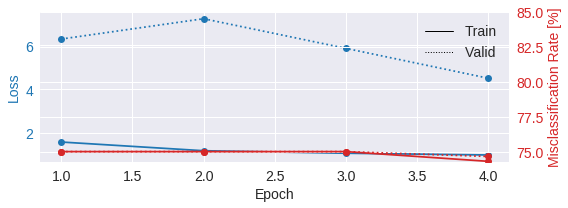

In [8]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import pandas as pd

# Extract loss and accuracy values for plotting from history object
results_columns = ['train_loss', 'valid_loss', 'train_accuracy', 'valid_accuracy']
df = pd.DataFrame(pipe.steps[-1][1].history[:, results_columns], columns=results_columns,
                  index=pipe.steps[-1][1].history[:, 'epoch'])

# get percent of misclass for better visual comparison to loss
df = df.assign(train_misclass=100 - 100 * df.train_accuracy,
               valid_misclass=100 - 100 * df.valid_accuracy)

plt.style.use('seaborn')
fig, ax1 = plt.subplots(figsize=(8, 3))
df.loc[:, ['train_loss', 'valid_loss']].plot(
    ax=ax1, style=['-', ':'], marker='o', color='tab:blue', legend=False, fontsize=14)

ax1.tick_params(axis='y', labelcolor='tab:blue', labelsize=14)
ax1.set_ylabel("Loss", color='tab:blue', fontsize=14)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

df.loc[:, ['train_misclass', 'valid_misclass']].plot(
    ax=ax2, style=['-', ':'], marker='o', color='tab:red', legend=False)
ax2.tick_params(axis='y', labelcolor='tab:red', labelsize=14)
ax2.set_ylabel("Misclassification Rate [%]", color='tab:red', fontsize=14)
ax2.set_ylim(ax2.get_ylim()[0], 85)  # make some room for legend
ax1.set_xlabel("Epoch", fontsize=14)

# where some data has already been plotted to ax
handles = []
handles.append(Line2D([0], [0], color='black', linewidth=1, linestyle='-', label='Train'))
handles.append(Line2D([0], [0], color='black', linewidth=1, linestyle=':', label='Valid'))
plt.legend(handles, [h.get_label() for h in handles], fontsize=14)
plt.tight_layout()